In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import os
import pc
import ecg_plot

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import optimize
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional

### Data Prep

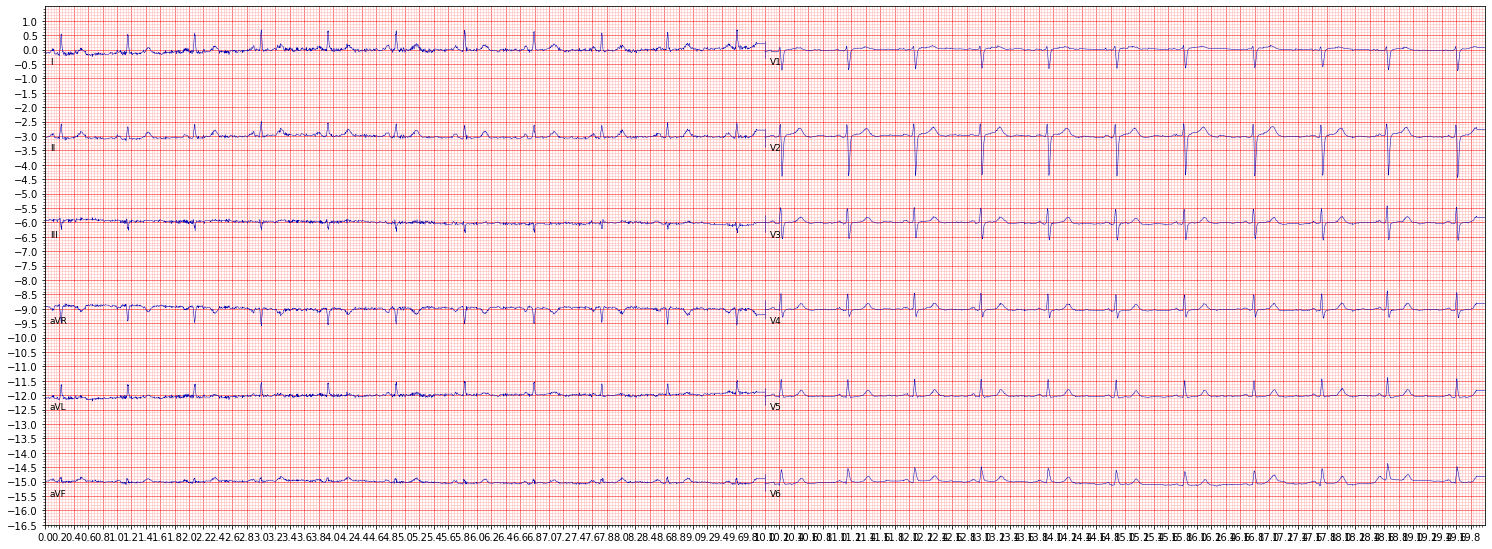

In [3]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
    
plot_ecg("WFDB/HR00001.mat")

In [ ]:
gender, age, labels, ecg_filenames = pc.import_key_data("WFDB/")

In [ ]:
ecg_filenames = np.asarray(ecg_filenames)

In [ ]:
SNOMED_scored = pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored = pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

In [ ]:
y , snomed_classes = pc.onehot_encode(df_labels)

In [ ]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

In [ ]:
y_all_comb = pc.get_labels_for_all_combinations(y)
folds = pc.split_data(labels, y_all_comb)
order_array = folds[0][0]

### Utility Functions

In [ ]:
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) 
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

In [ ]:
batchsize = 8

### Hybrid Model

In [ ]:
inp_ = tf.keras.layers.Input(shape=(5000, 12))
    
x = tf.keras.layers.Convolution1D(16, kernel_size = 5, activation = "relu", padding="valid")(inp_)
x = BatchNormalization()(x)
x = tf.keras.layers.Convolution1D(16, kernel_size = 5, activation = "relu", padding="valid")(x)
x = BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size = 2)(x)
x = tf.keras.layers.Dropout(rate = 0.1)(x)

x = tf.keras.layers.GlobalMaxPool1D()(x)
y = tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True))(inp_)
y = tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True))(y)
y = tf.keras.layers.GlobalMaxPool1D()(y)
x = tf.keras.layers.concatenate()([x,y])
x = tf.keras.layers.Dropout(rate = 0.25)(x)

x = tf.keras.layers.Dense(64, activation = "relu")(x)
x = tf.keras.layers.Dropout(rate = 0.25)(x)
out = tf.keras.layers.Dense(23, activation = 'sigmoid')(x)

hybrid_model = tf.keras.models.Model(inp_, out)

In [ ]:
hybrid_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), \
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                     metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5), tf.keras.metrics.Recall(name='Recall'), \
                              tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
hybrid_model.summary()

In [ ]:
plot_model(hybrid_model, show_shapes=True)

In [ ]:
hybrid_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=25, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

In [ ]:
plt.plot(hybrid_model.history.history['accuracy'])
plt.plot(hybrid_model.history.history['Precision'])
plt.plot(hybrid_model.history.history['val_accuracy'])
plt.plot(hybrid_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(hybrid_model.history.history['loss'])
plt.plot(hybrid_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(hybrid_model.history.history['Recall'])
plt.plot(hybrid_model.history.history['Precision'])
plt.plot(hybrid_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
hybrid_model.save('hybrid_model.h5')

### Conv1D-Stack

In [ ]:
model_conv1d = Sequential()

model_conv1d.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(5000,12)))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(Conv1D(filters=16, strides=1, kernel_size=5))
model_conv1d.add(BatchNormalization())
model_conv1d.add(Activation('relu'))
model_conv1d.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

model_conv1d.add(GlobalMaxPooling1D())

model_conv1d.add(Dense(64, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(32, activation='relu'))
model_conv1d.add(Dropout(0.25))
model_conv1d.add(Dense(23, activation='sigmoid'))

In [ ]:
model_conv1d.compile(loss = tf.keras.losses.BinaryCrossentropy(), \
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), \
                     metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5), tf.keras.metrics.Recall(name='Recall'), \
                              tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
model_conv1d.summary()

In [ ]:
plot_model(model_conv1d, show_shapes=True)

In [ ]:
model_conv1d.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), \
                                            gen_y=generate_y_shuffle(y)), epochs=25, \
                  steps_per_epoch=(len(order_array)/(batchsize*10)), \
                  validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), \
                  callbacks=[reduce_lr,early_stop])

In [ ]:
plt.plot(model_conv1d.history.history['accuracy'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['val_accuracy'])
plt.plot(model_conv1d.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(model_conv1d.history.history['loss'])
plt.plot(model_conv1d.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(model_conv1d.history.history['Recall'])
plt.plot(model_conv1d.history.history['Precision'])
plt.plot(model_conv1d.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
model_conv1d.save('conv1dstack.h5')

In [ ]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.InputLayer((5000,12)))
lstm_model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(tf.keras.layers.Bidirectional(LSTM(32, return_sequences = True)))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(23, activation = 'sigmoid'))

In [ ]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), \
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\
                   metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),\
                            tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
lstm_model.summary()

In [ ]:
plot_model(lstm_model, show_shapes = True)

In [ ]:
lstm_model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames),\
                                         gen_y=generate_y_shuffle(y)), epochs=25, \
               steps_per_epoch=(len(order_array)/(batchsize*10)), \
               validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]))

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
lstm_model.save('lstmmodel.h5')